# Epistatic Interactions
based on the code from [Phillips et al.](https://elifesciences.org/articles/71393#s4)

In [1]:
!pwd

/projects/brpe7306/fab-library-barcoding


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from remove_silent import convert_to_one_hot, remove_silent

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "figure.figsize": (7, 5),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

## Read in data

In [3]:
data = pd.read_csv(
    "/projects/brpe7306/fab-library-barcoding/MLE/output/4A8_CC121_combined_mle_all.csv"
)
data = data[data["Variant"].str.startswith("4A8")]
data["Variant"] = data["Variant"].apply(remove_silent)
data = data[data["n"] == 9]
print(len(data))
# Desired mutations: M59I, Q120K, S7T, T94M, V109L, and D110E
# Undesired mutations:
undesired_mutations = [
    "D52N-AAT",
    "Q105G-GGA",
    "Q120R-CGT",
    "S128P-CCA",
    "S88Y-TAT",
    "T122I-ATC",
    "T123L-CTG",
    "T76I-ATA",
    "W118C-TGC",
]
for mut in undesired_mutations:
    data = data[~data["Variant"].str.contains(mut)]
print(data)

594
                   Barcode                                            Variant  \
1     TTATACACGCTTATAGATGC                 4A8>VH:WT|4A8>VL:S7T-ACT;V109L-CTG   
2     TAATATGCAATTATTGGTAC                          4A8>VH:WT|4A8>VL:T94M-ATG   
3     ACTGCCGCCCGTATAGCTTT                     4A8>VH:M59I-ATC|4A8>VL:S7T-ACT   
4     TAGTATAGATATATGGCATT           4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG   
5     CTGGGCTGGTGCATGCATTC           4A8>VH:M59I-ATC|4A8>VL:S7T-ACT;D110E-GAG   
...                    ...                                                ...   
1111  TTTCATATATTTGATTAAAT  4A8>VH:M59I-ATC;Q120K-AAA|4A8>VL:V109L-CTG;D11...   
1121  AATTATGGATGTGAGTGTTT       4A8>VH:WT|4A8>VL:S7T-ACT;V109L-CTG;D110E-GAG   
1127  ATGCATTTGATCGCTCGAAG          4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;V109L-CTG   
1136  TTATATGCATGGAAGGCCTC            4A8>VH:M59I-ATC|4A8>VL:S7T-ACT;T94M-ATG   
1138  TAGCCTTCCTACGCACGTGC                          4A8>VH:M59I-ATC|4A8>VL:WT   

           Kd      Fmax

In [4]:
one_hots, mlb = convert_to_one_hot(data.loc[:, ("Variant")], keep_mlb=True)
data = data.join(
    pd.DataFrame.sparse.from_spmatrix(one_hots, index=data.index, columns=mlb.classes_)
)
mutations = mlb.classes_.tolist()[1:]
data.drop(columns=[""], inplace=True)
print(data.head())

                Barcode                                   Variant       Kd  \
1  TTATACACGCTTATAGATGC        4A8>VH:WT|4A8>VL:S7T-ACT;V109L-CTG    49.77   
2  TAATATGCAATTATTGGTAC                 4A8>VH:WT|4A8>VL:T94M-ATG   356.68   
3  ACTGCCGCCCGTATAGCTTT            4A8>VH:M59I-ATC|4A8>VL:S7T-ACT    42.25   
4  TAGTATAGATATATGGCATT  4A8>VH:Q120K-AAA|4A8>VL:S7T-ACT;T94M-ATG  2050.91   
5  CTGGGCTGGTGCATGCATTC  4A8>VH:M59I-ATC|4A8>VL:S7T-ACT;D110E-GAG    50.47   

       Fmax  Success     LL                                           Rijk  \
1  28699.63     True  12.69  [143, 276, 213, 314, 285, 345, 247, 332, 380]   
2  19847.27     True   5.50           [39, 12, 40, 12, 23, 18, 42, 30, 24]   
3  31532.36     True   2.25       [49, 97, 78, 116, 98, 103, 73, 111, 131]   
4  39845.13     True  13.23               [6, 13, 10, 2, 6, 14, 28, 12, 8]   
5  44286.67     True   7.99  [136, 173, 130, 159, 153, 195, 152, 197, 237]   

                                      Concentrations  \
1  [50

# Making Arrays for Regression

In [5]:
affinities = data[["Fmax"]].values.flatten().astype(np.float64)
print(affinities.shape)
print(mutations)
genotypes = np.array(data[[x for x in mutations]].copy(), dtype=int)
print(genotypes.shape)

(586,)
['D110E-GAG', 'M59I-ATC', 'Q120K-AAA', 'S7T-ACT', 'T94M-ATG', 'V109L-CTG']
(586, 6)


## CV to choose optimal order of interaction

In [6]:
num_folds = 10
max_order = 6

# set up permutation
np.random.seed(7802)
indices_permuted = np.random.permutation(np.arange(len(genotypes)))
size_test = int(1.0 / float(num_folds) * len(genotypes))
size_train = len(genotypes) - size_test
print(size_test, size_train)

# lists to store r squared values
rsq_train_list = np.zeros((max_order + 1, num_folds))
rsq_test_list = np.zeros((max_order + 1, num_folds))

# loop over CV folds
for f in range(num_folds):
    # get train & test sets
    start = int(f * size_test)
    stop = int((f + 1) * size_test)
    genos_train = np.concatenate(
        (genotypes[indices_permuted[:start]], genotypes[indices_permuted[stop:]])
    )
    genos_test = genotypes[indices_permuted[start:stop]]
    affinities_train = np.concatenate(
        (affinities[indices_permuted[:start]], affinities[indices_permuted[stop:]])
    )
    affinities_test = affinities[indices_permuted[start:stop]]

    print("Fold: ", f)

    # initialize zero-order (intercept-only) model
    genos_train_previous = np.full(len(genos_train), 1.0)
    genos_test_previous = np.full(len(genos_test), 1.0)

    reg_previous = sm.OLS(affinities_train, genos_train_previous).fit()
    reg_coefs_previous = reg_previous.params

    rsquared_train_previous = reg_previous.rsquared
    rsquared_test_previous = 1 - np.sum(
        (affinities_test - reg_previous.predict(genos_test_previous)) ** 2
    ) / np.sum((affinities_test - np.mean(affinities_test)) ** 2)
    rsq_train_list[0, f] = rsquared_train_previous
    rsq_test_list[0, f] = rsquared_test_previous

    # mean_pheno_train = np.mean(affinities_train)
    # mean_pheno_test = np.mean(affinities_test)

    # fit models of increasing order
    for order in range(1, max_order + 1):
        # print('Order: ',str(order))
        poly_current = PolynomialFeatures(order, interaction_only=True)
        genos_train_current = poly_current.fit_transform(genos_train)
        genos_test_current = poly_current.fit_transform(genos_test)

        reg_current = sm.OLS(affinities_train, genos_train_current).fit()
        reg_coefs_current = reg_current.params
        # print(reg_coefs_current) # FIXME
        reg_CIs_current = reg_current.conf_int(alpha=0.05, cols=None)
        reg_stderr = reg_current.bse
        # NOTE: Use mse_resid for BIC if you choose to use that

        rsquared_train_current = reg_current.rsquared
        rsquared_test_current = 1 - np.sum(
            (affinities_test - reg_current.predict(genos_test_current)) ** 2
        ) / np.sum((affinities_test - np.mean(affinities_test)) ** 2)
        rsq_train_list[order, f] = rsquared_train_current
        rsq_test_list[order, f] = rsquared_test_current

# average over folds
mean_rsq_train = np.mean(rsq_train_list, axis=1)
stdev_rsq_train = np.std(rsq_train_list, axis=1)
mean_rsq_test = np.mean(rsq_test_list, axis=1)
stdev_rsq_test = np.std(rsq_test_list, axis=1)

optimal_order = np.argmax(mean_rsq_test)
print("Optimal order: ", optimal_order)

58 528
Fold:  0
Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5
Fold:  6
Fold:  7
Fold:  8
Fold:  9
Optimal order:  2


In [7]:
# print CV results to file
with open("./Output/CV_rsquared.csv", "w") as writefile:
    rsq_writer = csv.writer(writefile)
    rsq_writer.writerow(["Type", "Order", "Mean", "Std"])
    for i in range(len(mean_rsq_train)):
        rsq_writer.writerow(["Train", str(i), mean_rsq_train[i], stdev_rsq_train[i]])
    for i in range(len(mean_rsq_test)):
        rsq_writer.writerow(["Test", str(i), mean_rsq_test[i], stdev_rsq_test[i]])
    writefile.close()

## Fit final models

Order:  1
Params:  7
Performance:  0.44472093541627766
Number of significant parameters: 6
Significant parameters:  ['1' 'D110E-GAG' 'M59I-ATC' 'Q120K-AAA' 'T94M-ATG' 'V109L-CTG']


ORDER: 1


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     467.7
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.23e-76
Time:                        16:09:30   Log-Likelihood:                -5678.6
No. Observations:                 586   AIC:                         1.136e+04
Df Residuals:                     584   BIC:                         1.137e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

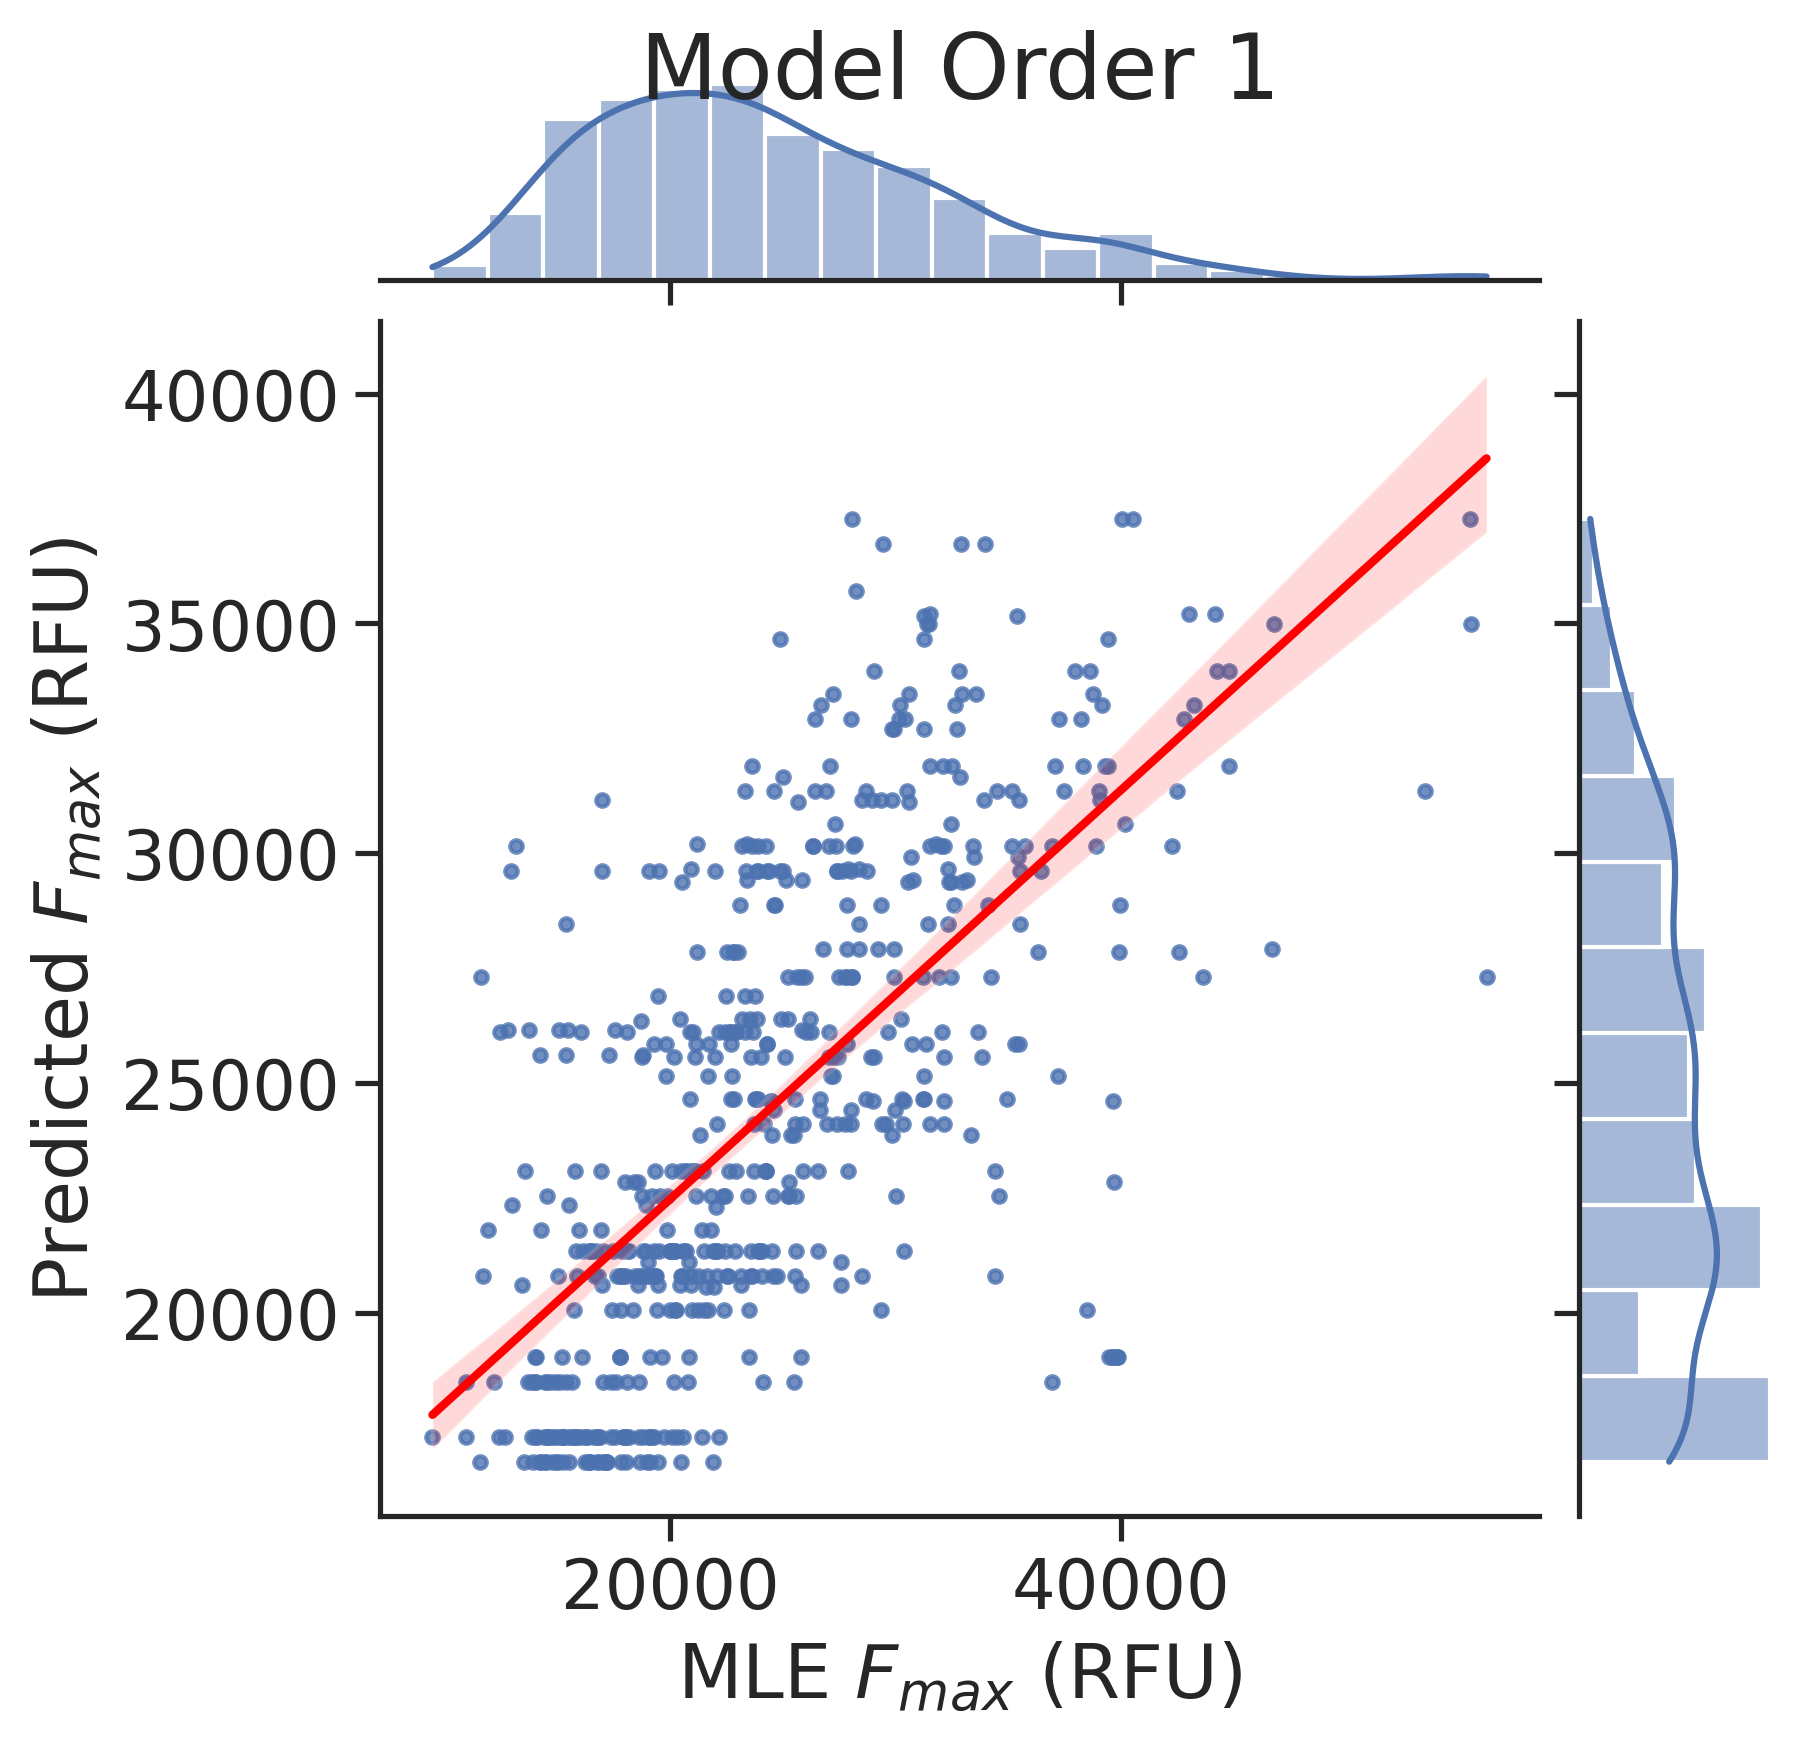

Order:  2
Params:  22
Performance:  0.5062871894628789
Number of significant parameters: 8
Significant parameters:  ['1' 'D110E-GAG' 'M59I-ATC' 'Q120K-AAA' 'V109L-CTG' 'D110E-GAG T94M-ATG'
 'M59I-ATC T94M-ATG' 'T94M-ATG V109L-CTG']


ORDER: 2


                            OLS Regression Results                            
Dep. Variable:              Predicted   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     598.9
Date:                Tue, 18 Apr 2023   Prob (F-statistic):           1.45e-91
Time:                        16:09:30   Log-Likelihood:                -5682.2
No. Observations:                 586   AIC:                         1.137e+04
Df Residuals:                     584   BIC:                         1.138e+04
Df Model:                           1                                         
Covariance Type:            nonrobust       

<Figure size 600x600 with 0 Axes>

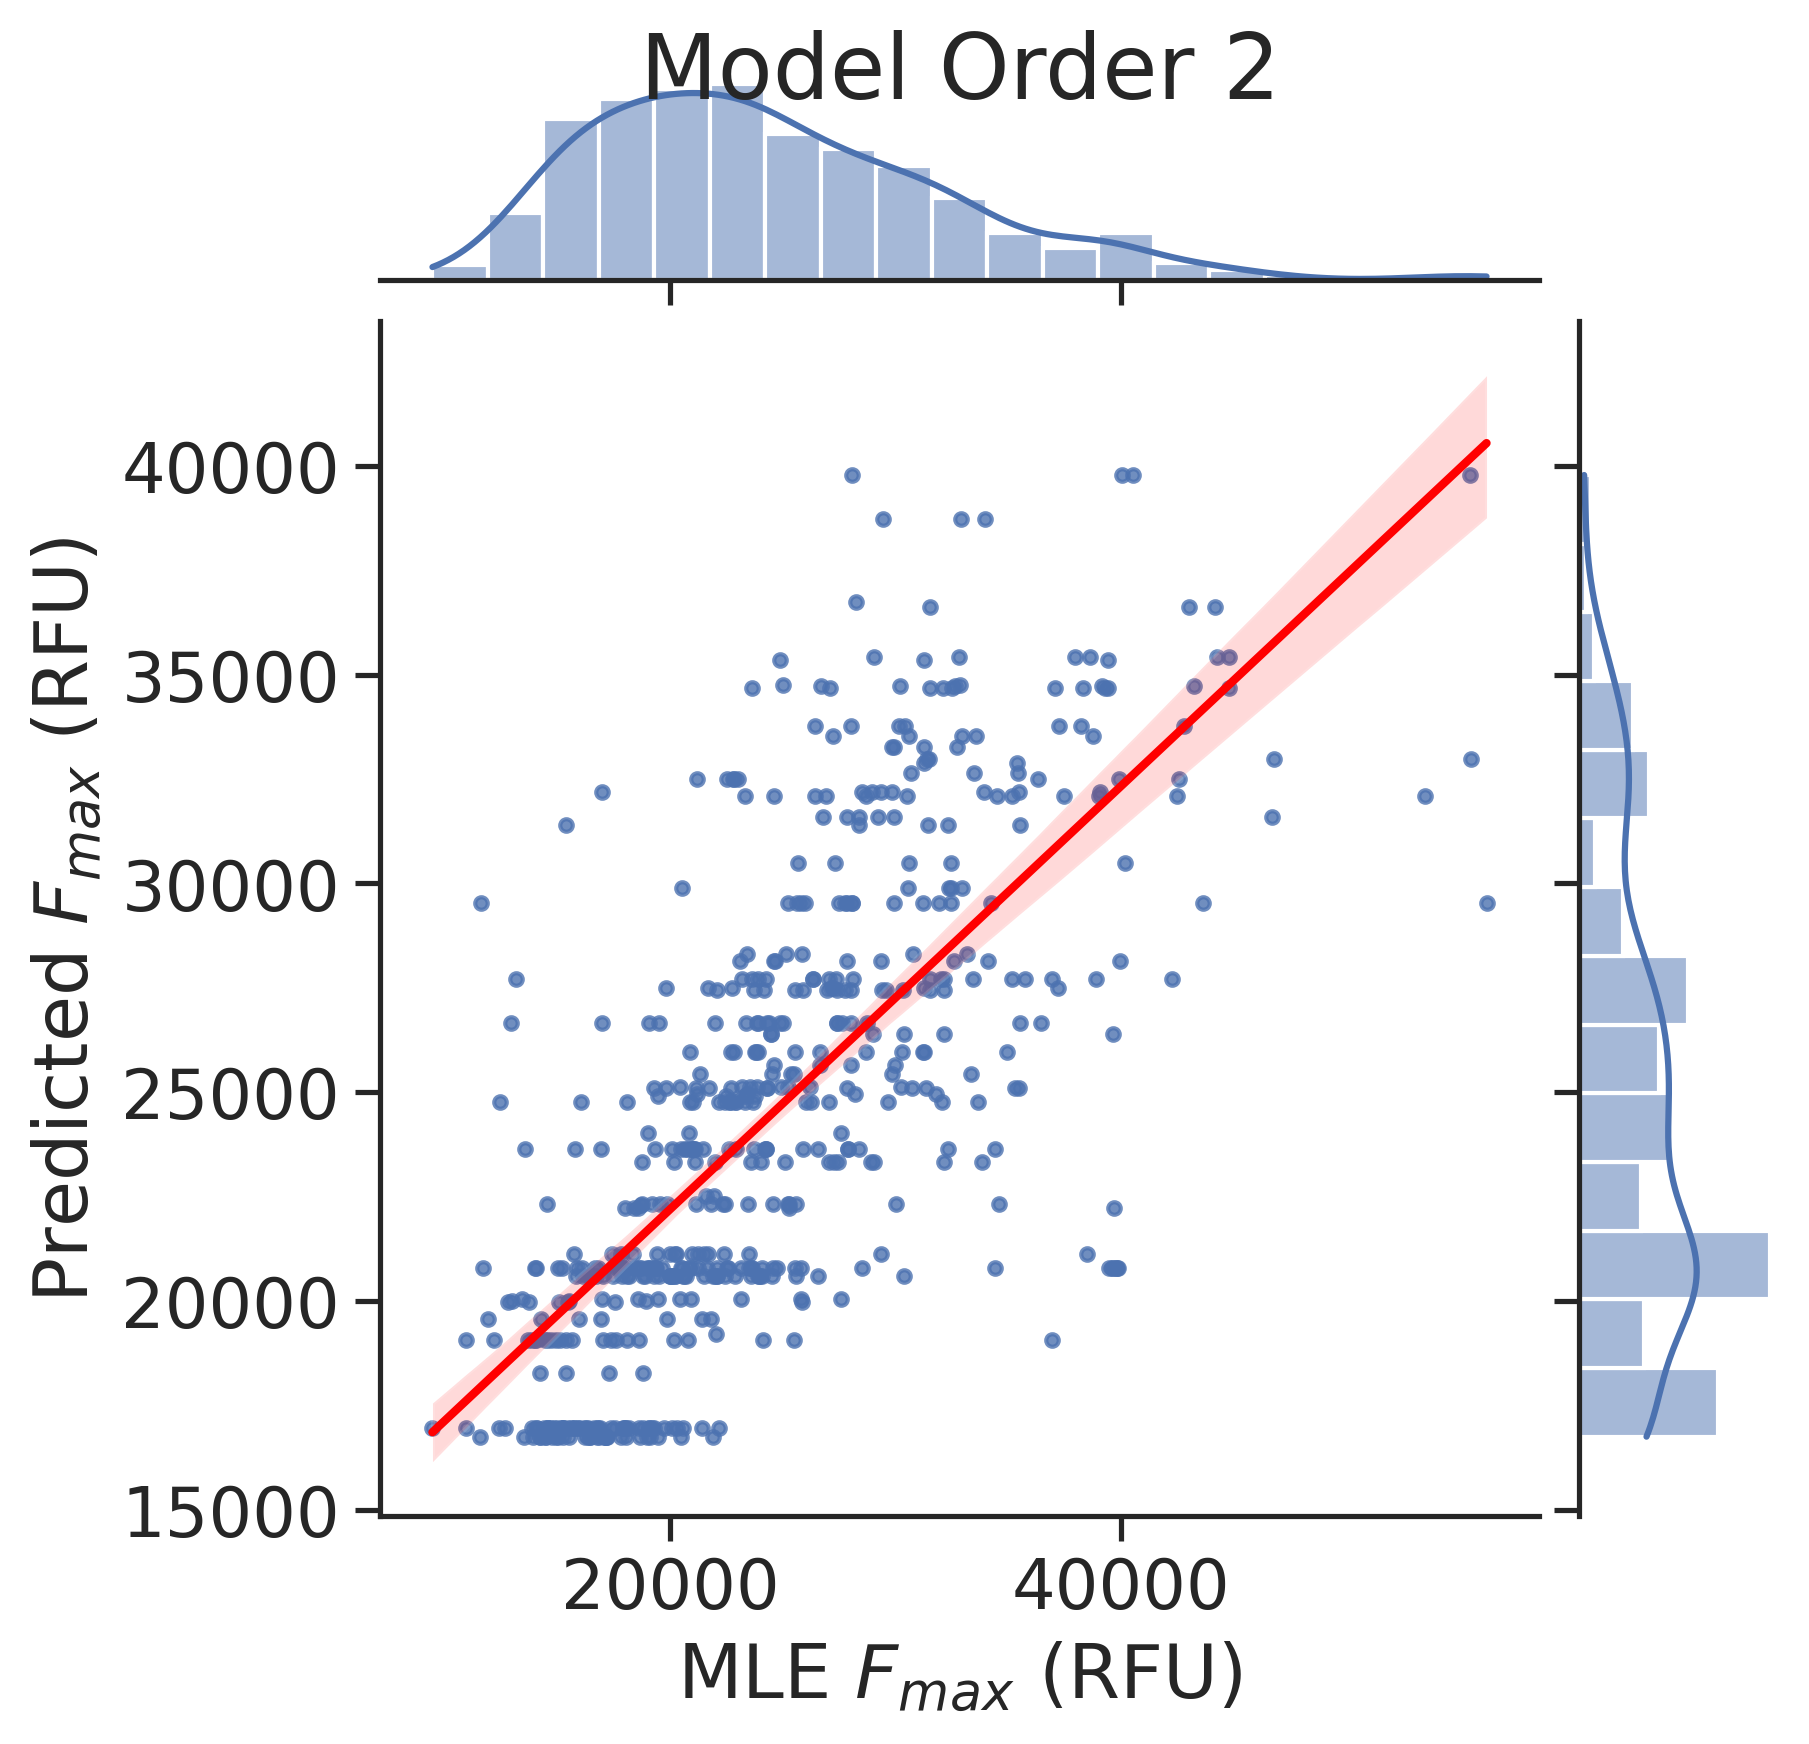

<Figure size 600x600 with 0 Axes>

In [9]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "figure.figsize": (2, 2),
}
sns.set(rc=custom_params, style="ticks", font_scale=1.5)

# fit models of increasing order
from patsy import dmatrices

for order in range(1, 3):  # optimal_order+2
    genotypes_permuted = genotypes[indices_permuted]
    affinities_permuted = affinities[indices_permuted]
    print("Order: ", str(order))
    poly_current = PolynomialFeatures(order, interaction_only=True)
    genotypes_current = poly_current.fit_transform(genotypes_permuted)

    # fit
    reg_current = sm.OLS(affinities_permuted, genotypes_current).fit()
    reg_coefs_current = reg_current.params
    reg_CIs_current = reg_current.conf_int(
        alpha=0.05 / float(len(reg_coefs_current)), cols=None
    )
    reg_stderr = reg_current.bse
    reg_pvalues = reg_current.pvalues

    num_sig = len(np.where(reg_pvalues < 0.05 / float(len(reg_coefs_current)))[0])

    predicted_phenos_permuted = reg_current.predict(genotypes_current)
    rsquared_current = reg_current.rsquared
    print("Params: ", len(reg_coefs_current))
    print("Performance: ", rsquared_current)
    print(f"Number of significant parameters: {num_sig}")

    # write model to file
    if order > 0:
        coef_names = poly_current.get_feature_names_out(input_features=mutations)
        print(
            "Significant parameters: ",
            coef_names[np.where(reg_pvalues < 0.05 / float(len(reg_coefs_current)))[0]],
        )
        with open("./Output/" + str(order) + "order.csv", "w") as writefile:
            coef_writer = csv.writer(writefile, delimiter=",")
            coef_writer.writerow(
                [
                    "Term",
                    "Coefficient",
                    "Standard Error",
                    "p-value",
                    "95% CI lower",
                    "95% CI upper",
                ]
            )
            coef_writer.writerow(["Intercept", reg_coefs_current[0]])
            for i in range(1, len(reg_coefs_current)):
                coef_writer.writerow(
                    [
                        ",".join(coef_names[i].split(" ")),
                        reg_coefs_current[i],
                        reg_stderr[i],
                        reg_pvalues[i],
                        reg_CIs_current[i][0],
                        reg_CIs_current[i][1],
                    ]
                )
            writefile.close()

        df = pd.DataFrame(
            {"Predicted": predicted_phenos_permuted, "Actual": affinities_permuted}
        )

        y, X = dmatrices("Predicted ~ Actual", data=df, return_type="dataframe")

        X -= np.average(X)  # to avoid high Cond. no.

        model = sm.OLS(y, X)
        results = model.fit()
        print(f"\n\nORDER: {order}\n\n")
        print(results.summary())
        plot = sns.jointplot(
            x="Actual",
            y="Predicted",
            data=df,
            kind="reg",
            line_kws={"lw": 2, "color": "red"},
            marker=".",
        )
        plot.fig.suptitle(f"Model Order {order}")
        plot.ax_joint.set_xlabel(r"MLE $F_{max}$ (RFU)")
        plot.ax_joint.set_ylabel(r"Predicted $F_{max}$ (RFU)")
        plt.show()
        # plt.savefig(f"../images/cr6261_model_order{order}.png", bbox_inches='tight')
        plt.clf()